# Baseline mode. Dataset pre-processing, skin patches extraction and color estimation

In [1]:
import sys
sys.path.append('/home/dasec-notebook/Thesis/OFIQ-Project/python')
sys.path.append('../')

import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np
from colormath.color_objects import LabColor
from skimage.color import deltaE_ciede2000
from skimage.color import rgb2lab

from ofiq_zmq import OfiqZmq
from utils import baseline_utils

%load_ext autoreload
%autoreload 2


In [2]:
ofiq_zmq = OfiqZmq("/home/dasec-notebook/Thesis/OFIQ-Project")

dataset_portrait_path = (
    "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2"
)

# Generate dataset image lists

In [15]:
input_folder = (
    "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2"
)
indoor_file = "indoor.txt"
outdoor_file = "outdoor.txt"

Sort indoor and outdoor images for CHROMA-FIT-Dataset


In [ ]:
with open(indoor_file, "w") as indoor_f, open(outdoor_file, "w") as outdoor_f:
    for subdir, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".JPEG", ".PNG", "JPG")):
                image_path = os.path.join(subdir, file)
                if baseline_utils.is_indoor(image_path):
                    indoor_f.write(image_path + "\n")
                else:
                    outdoor_f.write(image_path + "\n")

print(f"Indoor images saved to {indoor_file}")
print(f"Outdoor images saved to {outdoor_file}")

Generate MST image list


In [20]:
input_folder = "/home/dasec-notebook/Thesis/Datasets/mst-e_data/CSEC"
mst_file = "image_paths/MST_CSEC.txt"

with open(mst_file, "w") as f:
    for subdir, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".JPEG", ".PNG", "JPG")):
                image_path = os.path.join(subdir, file)
                f.write(image_path + "\n")

Display all images

Used to double check the sorting of indoor and outdoor images from CHROMA-FIT dataset

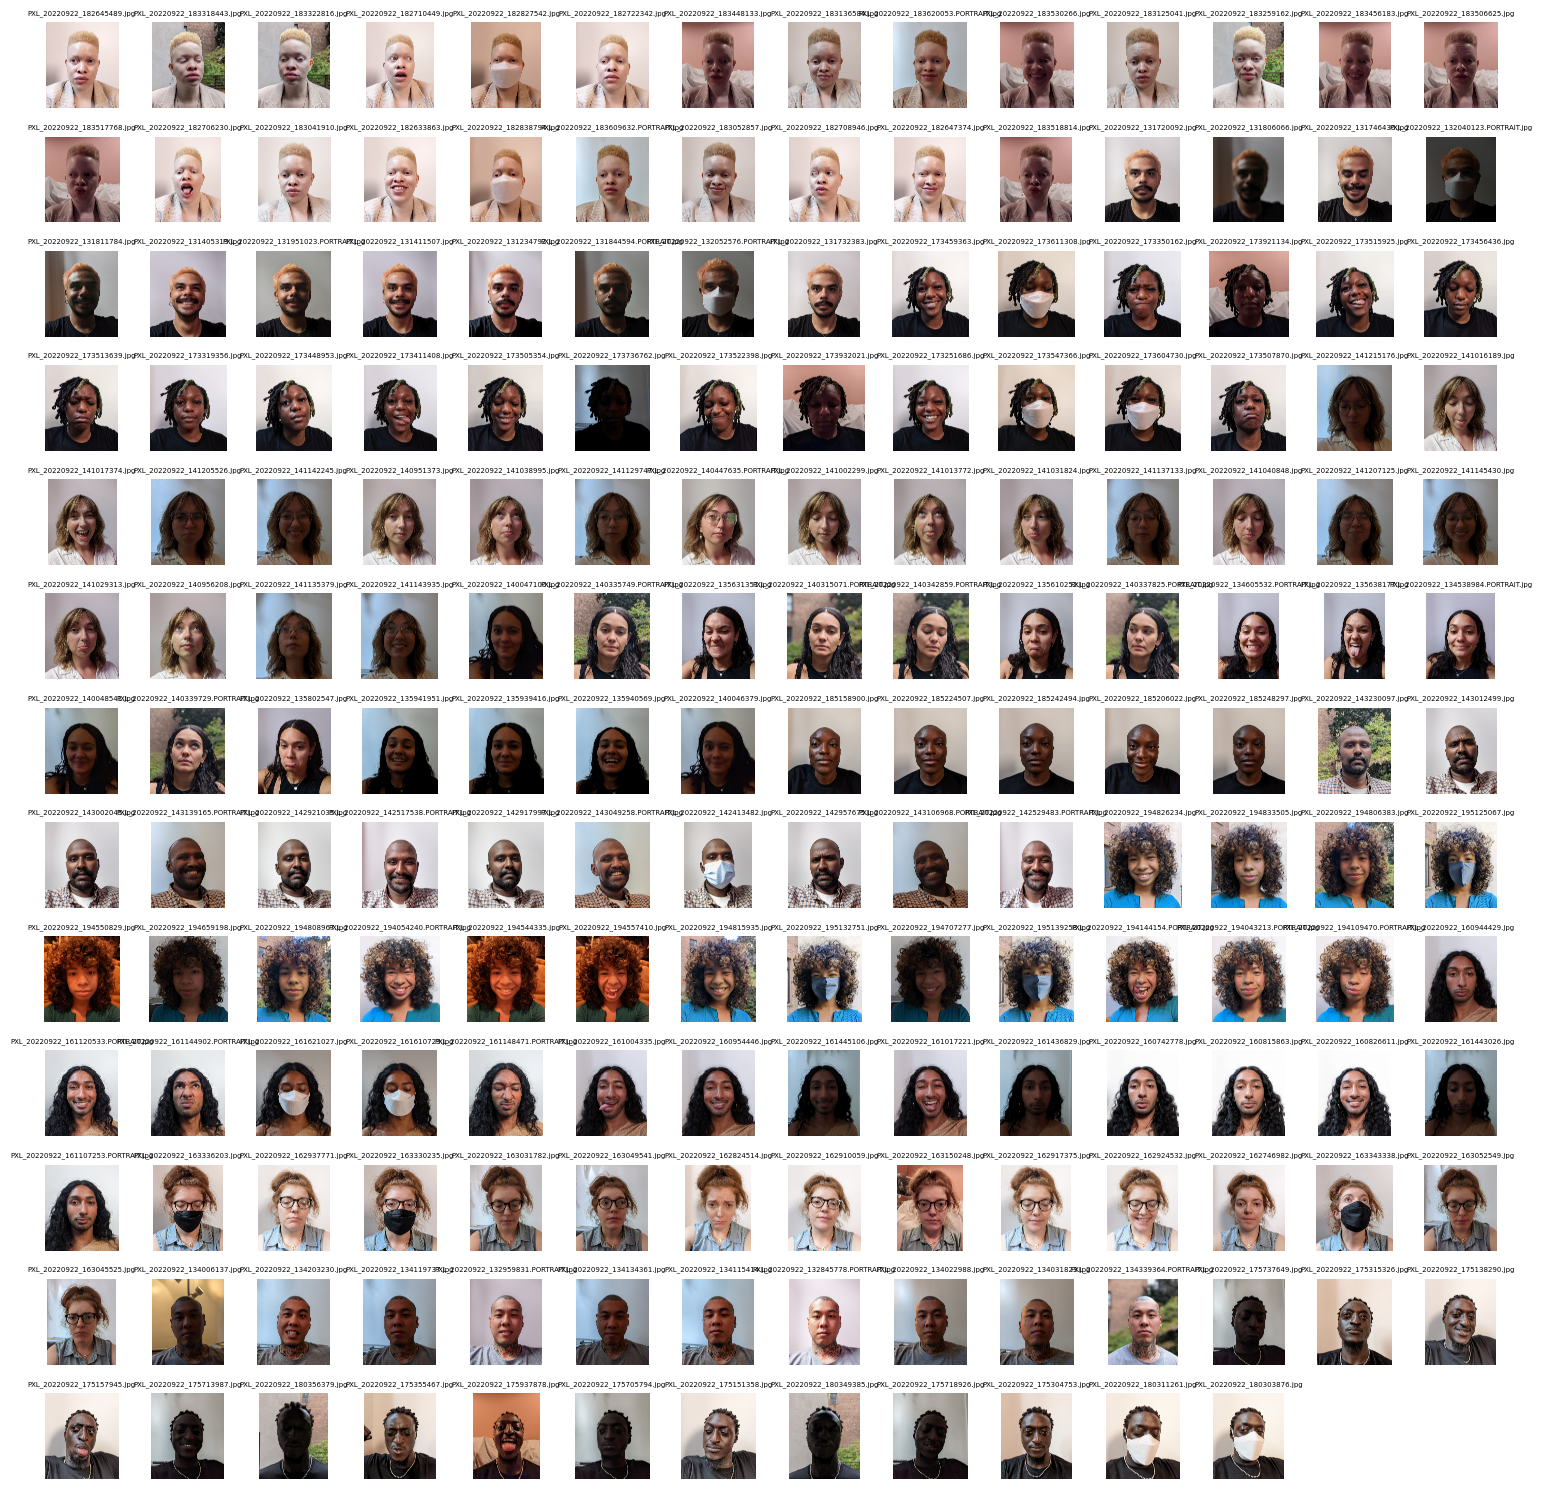

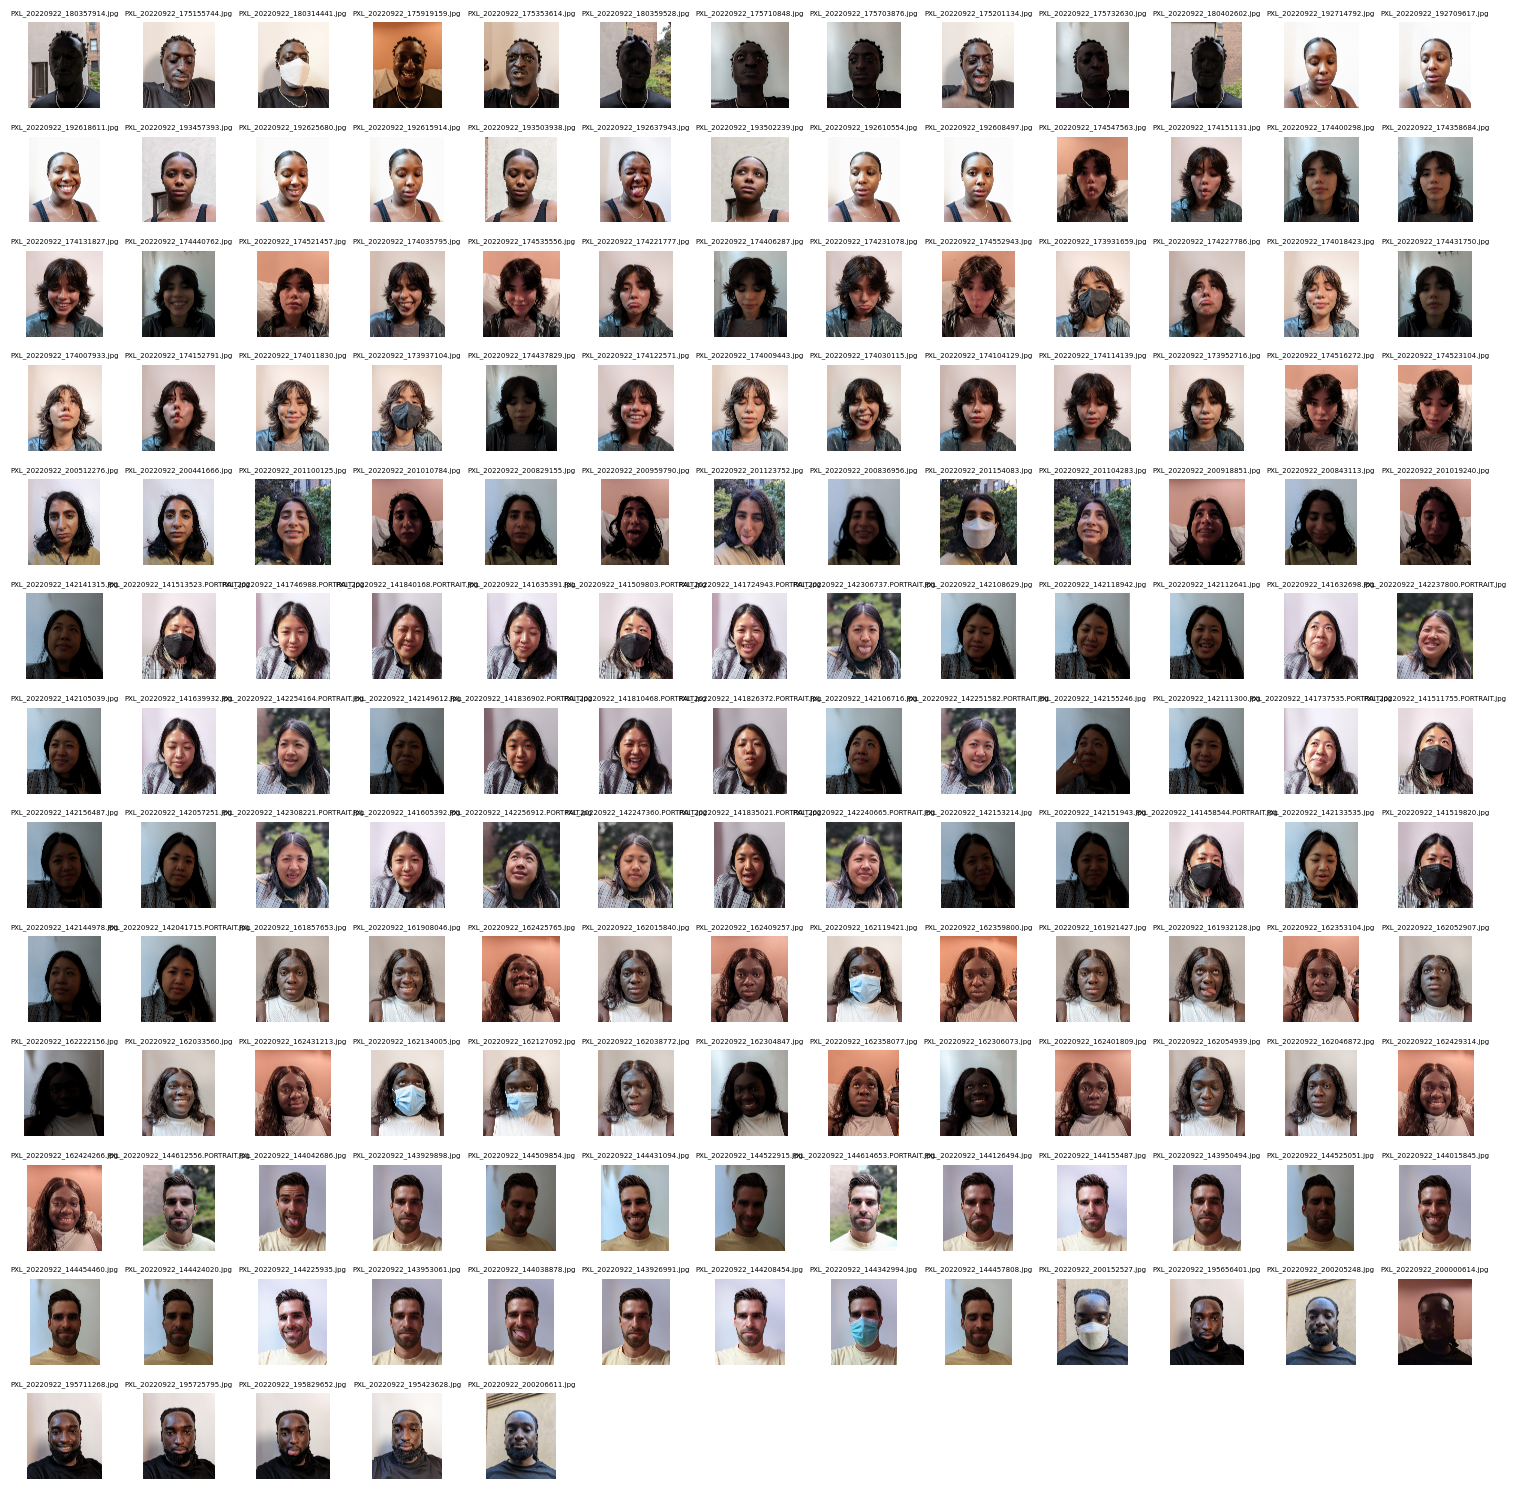

In [4]:
indoor_file = "indoor.txt"
outdoor_file = "outdoor.txt"
mst_file = "MST.txt"

# Display all indoor images
baseline_utils.display_images(indoor_file)

# Display all outdoor images
baseline_utils.display_images(outdoor_file)

# Display all MST images
baseline_utils.display_images(mst_file)

# Plot 15 images with landmarks, mask and extracted skin patches

Used to visualize the cheek patches and landmark estimation.

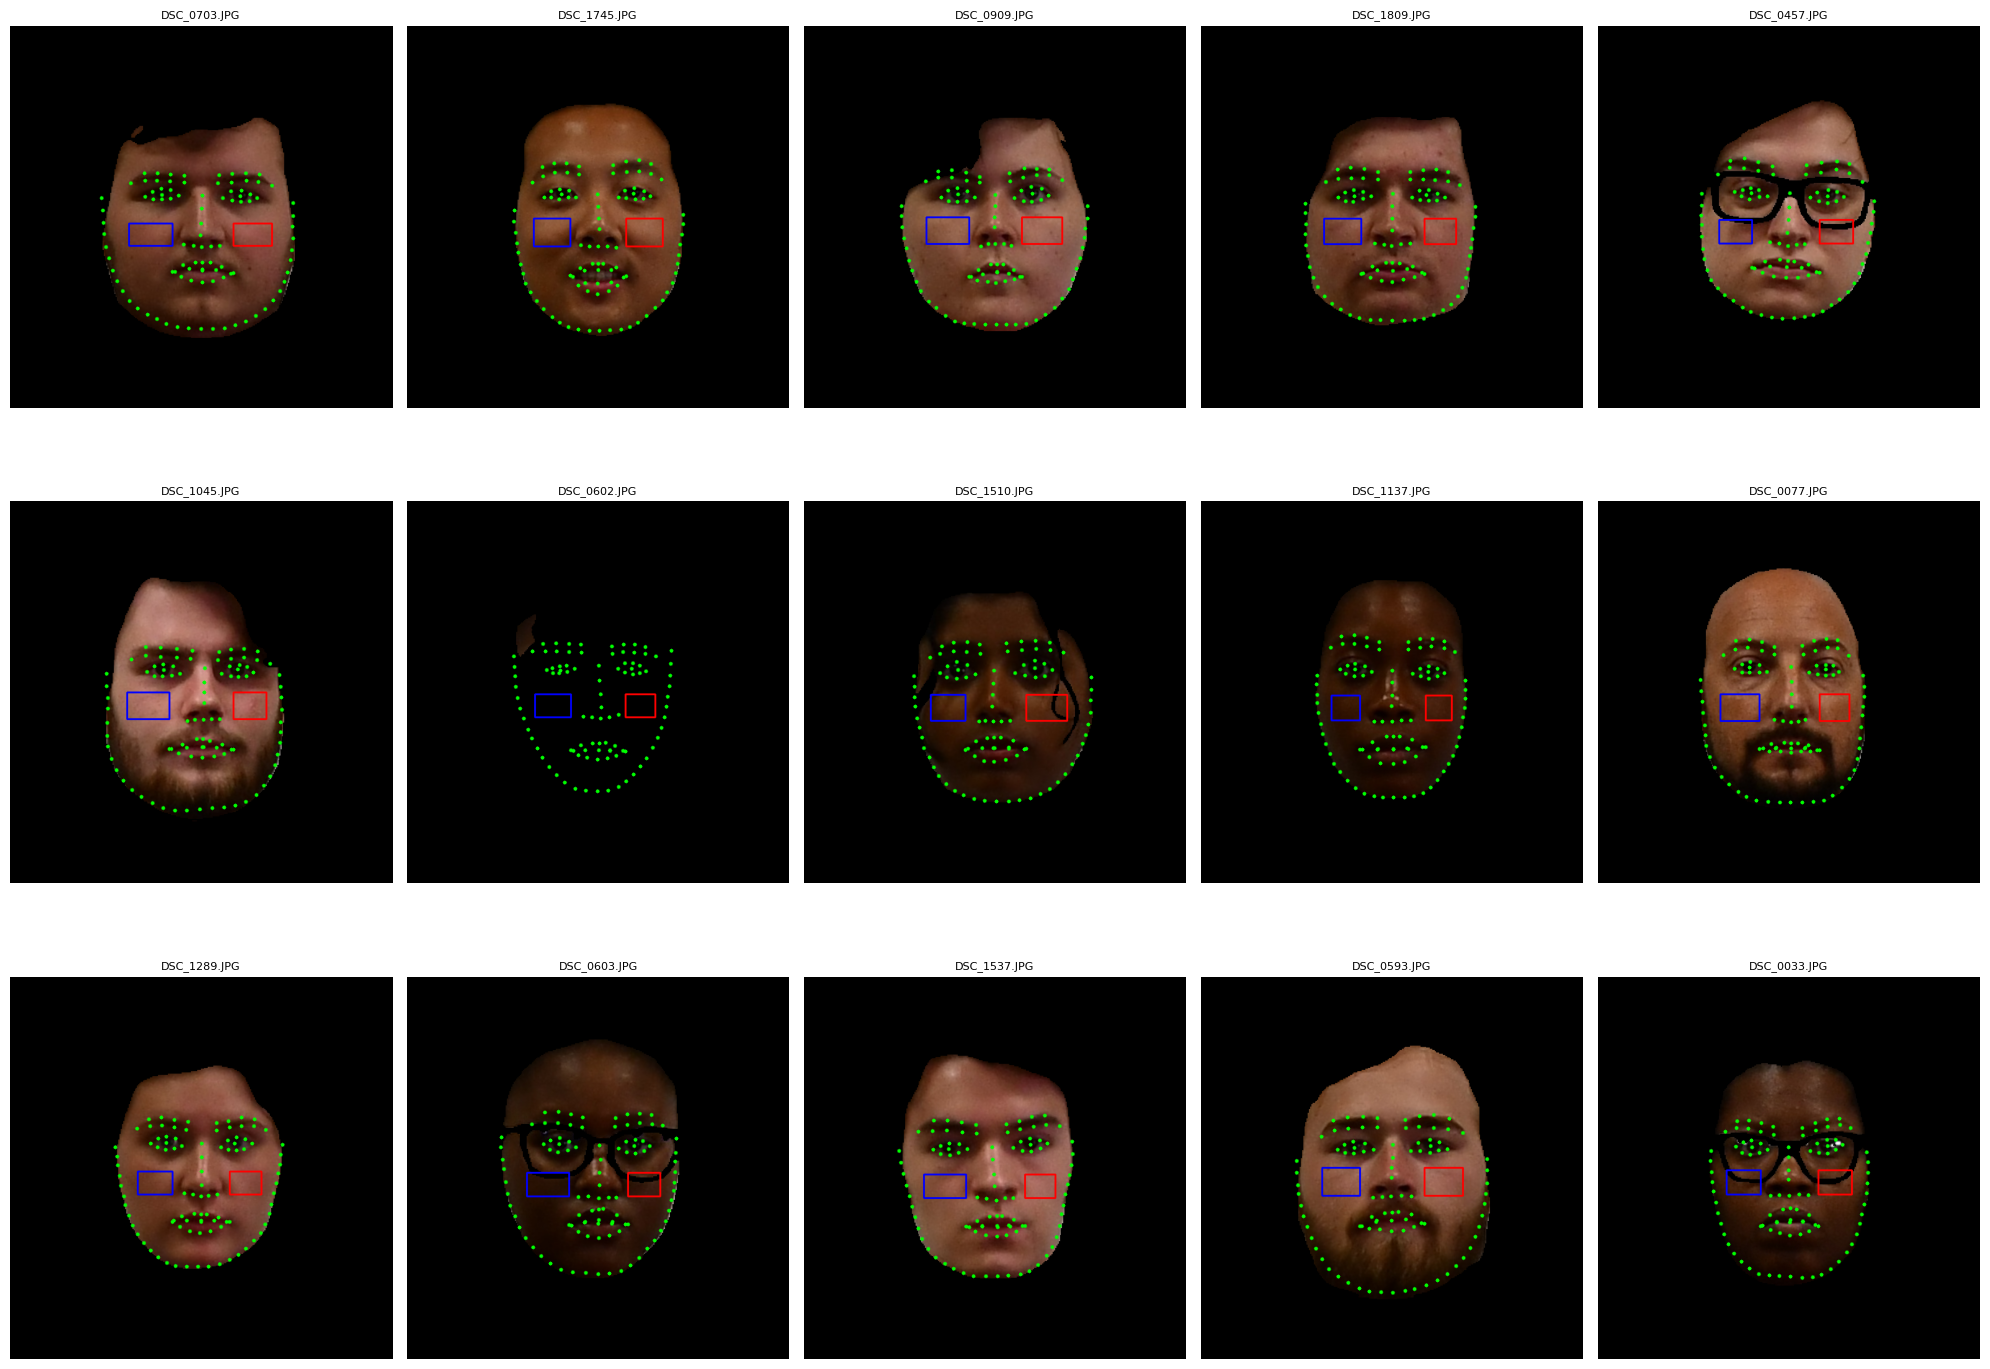

[OFIQ_zmq_app][INFO] Shutdown due to receive timeout.


In [4]:
dataset_path = (
    "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2"
)

file_path = "../image_paths/CHROMA-FIT_indoor.txt"  # NOTE: change the file name to the required one

with open(file_path, "r") as f:
    image_paths = [line.strip() for line in f if line.strip()]

# select the first 15 images
image_paths = image_paths[:15]

# Append dataset path to all image paths
image_paths = [os.path.join(dataset_path, path) for path in image_paths]

rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

for i, img_path in enumerate(image_paths):
    row, col = divmod(i, cols)

    result = ofiq_zmq.process_image(img_path)
    img = result["aligned_face"][0]

    landmarks = np.array(
        [[point.x, point.y] for point in result["aligned_face_landmarks"][1]]
    )
    mask = result["face_occlusion_segmentation_image"][0]

    # NOTE: remove the mask to see the original image if needed
    masked_img = mask * img

    processed_img = baseline_utils.image_with_rect(masked_img, landmarks)

    axes[row, col].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    axes[row, col].axis("off")
    axes[row, col].set_title(os.path.basename(img_path), fontsize=8)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

# Extract the skin patches and save RGBs to a file

Extracts left and right check RGB and calculates the mean to determine the RGB color of a skin tone. 

One cheek RGB is calculated by averaging skin patches of size 10x10 and sliding it by the stride of 5 pixels.

In [ ]:
dataset = "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2_illuminant_correction/exposure_color_correction"
image_paths = baseline_utils.get_image_paths(dataset)

output_json_file = "../baseline/results/cheek_colors_extracted/CHROMA-FIT_exposure_color_correction.json"  # Output JSON file name

baseline_utils.extract_skin_patch_RGBs(image_paths, output_json_file)

Split into indoor and outdoor files

In [12]:
json_file = "../baseline/results/cheek_colors_extracted/CHROMA-FIT_exposure_color_correction.json"

indoor_txt = "../image_paths/CHROMA-FIT_indoor.txt"
outdoor_txt = "../image_paths/CHROMA-FIT_outdoor.txt"
output_indoor_json = "../baseline/results/cheek_colors_extracted/CHROMA-FIT_exposure_color_correction_indoor.json"
output_outdoor_json = "../baseline/results/cheek_colors_extracted/CHROMA-FIT_exposure_color_correction_outdoor.json"

baseline_utils.split_json_by_paths(
    json_file, indoor_txt, outdoor_txt, output_indoor_json, output_outdoor_json
)

# Calculate accuracy of baseline model

CHROMA-FIT

Generate Ground Truths for CHROMA-FIT dataset by mapping RGB to MST.

Mapping is described in CHROMA-FIT paper, and follows these steps:

1. Convert RGB values from the .CSV into linear RGB. 
2. Extract salient colors from each MST orb image using a K-means clustering algorithm. 
3. Calculate the Root Mean Square Error (RMSE) between the linear RGB values for each subject and the cluster centers obtained from the MST orbs. 
4. Assign an MST rating to each subject based on the orb with the lowest RMSE.

Calculation is based on forehead measurements. Experiments were done on the forearm measurement as well.

In [ ]:
data = pd.read_csv(
    "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/Metadata.csv"
)
mst_orb_dir = "/home/dasec-notebook/Thesis/Datasets/MST Orbs/orbs"
save_file = "baseline_results/ground_truth_RGB_MST_forehead.csv"

# Load all MST orb salient colors in a dictionary
mst_orb_salient_colors = {}
for filename in os.listdir(mst_orb_dir):
    if filename.endswith(".png"):
        image_path = os.path.join(mst_orb_dir, filename)
        salient_colors = baseline_utils.extract_salient_colors(image_path)
        mst_orb_salient_colors[filename] = salient_colors

results = []

# Iterate through each subject's Forearm RGB values
for index, row in data.iterrows():

    # Convert subject's Forearm RGB values to linear RGB
    forehead_rgb = [row["Forehead_R"], row["Forehead_G"], row["Forehead_B"]]
    linear_forearm_rgb = baseline_utils.linear_rgb(forehead_rgb)

    best_mst_orb = None
    lowest_rmse = float("inf")

    # Compare against each MST orb's salient colors
    for mst_orb_name, salient_colors in mst_orb_salient_colors.items():

        linear_salient_colors = [
            baseline_utils.linear_rgb(color) for color in salient_colors
        ]
        rmse, _ = baseline_utils.compute_rmse(linear_forearm_rgb, linear_salient_colors)

        if rmse < lowest_rmse:
            lowest_rmse = rmse
            best_mst_orb = mst_orb_name.split(".")[0].split("_")[1]

    results.append(
        {
            "ID": row["ID"],
            "Ground_Truth_MST_Orb": best_mst_orb,  # Best MST orb file for this subject
            "Lowest_RMSE": lowest_rmse,
        }
    )

results_df = pd.DataFrame(results)
results_df.to_csv(save_file, index=False)

print("Best MST orbs calculated and saved to ", save_file)

Generate Ground Truths for CHROMA-FIT dataset by mapping L*a*b* color space to MST.

Mapping is described in CHROMA-FIT paper, and follows these steps:

1. Convert RGB values to L*a*b*
2. Calculate CIEDE2000 Differences: Use the CIEDE2000 formula to calculate the perceptual difference between each subject's color and the salient colors in each MST orb.
3. Assign MST Rating: Find the MST orb with the lowest cumulative CIEDE2000 value and assign that MST rating to each subject.


In [15]:
# Load data and set paths
data = pd.read_csv(
    "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/Metadata.csv"
)
mst_orb_dir = "/home/dasec-notebook/Thesis/Datasets/MST Orbs/orbs"
save_file = "baseline_results/ground_truth_Lab_MST_forearm.csv"


# Generate MST orb salient colors in Lab space
mst_orb_salient_colors = {}
for filename in os.listdir(mst_orb_dir):
    if filename.endswith(".png"):
        image_path = os.path.join(mst_orb_dir, filename)
        salient_colors_rgb = baseline_utils.extract_salient_colors(image_path)

        salient_colors_rgb_scaled = salient_colors_rgb / 255.0
        salient_colors_lab = rgb2lab(salient_colors_rgb_scaled)

        mst_orb_salient_colors[filename] = salient_colors_lab


results = []

# Iterate through each subject's Forearm L*a*b* values
for index, row in data.iterrows():

    # Extract subject's Forearm L*a*b* values
    colors_lab = LabColor(
        lab_l=row["Forearm_L"], lab_a=row["Forearm_a"], lab_b=row["Forearm_b"]
    )

    lab_array = np.array([colors_lab.lab_l, colors_lab.lab_a, colors_lab.lab_b])

    best_mst_orb = None
    lowest_ciede2000 = float("inf")

    # Compare against each MST orb's salient colors in Lab space
    for mst_orb_name, salient_colors_lab in mst_orb_salient_colors.items():

        ciede2000_values = [
            deltaE_ciede2000(lab_array, np.array(color)) for color in salient_colors_lab
        ]

        # Find the minimum CIEDE2000 for the orb
        min_ciede2000 = min(ciede2000_values)

        if min_ciede2000 < lowest_ciede2000:
            lowest_ciede2000 = min_ciede2000
            best_mst_orb = mst_orb_name.split(".")[0].split("_")[1]

    results.append(
        {
            "ID": row["ID"],
            "Ground_Truth_MST_Orb": best_mst_orb,
            "Lowest_CIEDE2000": lowest_ciede2000,
        }
    )

# Save the results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(save_file, index=False)

print("Best MST orbs calculated and saved to", save_file)

Best MST orbs calculated and saved to baseline_results/ground_truth_Lab_MST_forearm.csv


There are 4 different MST mappings which come from:

1. RGB forearm measurements
2. RGB forehead measurements
3. L*a*b* forearm measurements
4. L*a*b* forehead measurements

As described in CHROMA-FIT paper, to determine the final mapping, all of the assigned MST categories from 4 different models are compared. In instances where two modes were identified for a particular subject, we calculated the median of these modes and designated it as the ground-truth MST rating.

In [ ]:
# Define file paths for the 4 MST mapping files
files = {
    "RGB_forearm": "image_paths/ground_truth_RGB_MST_forearm.csv",
    "LAB_forearm": "image_paths/ground_truth_Lab_MST_forearm.csv",
    "RGB_forehead": "image_paths/ground_truth_RGB_MST_forehead.csv",
    "LAB_forehead": "image_paths/ground_truth_Lab_MST_forehead.csv",
}

output_file = "image_paths/ground_truth_CHROMA-FIT.csv"

data = {key: pd.read_csv(file) for key, file in files.items()}

# Rename MST column to uniquely identify each source and combine based on the 'ID' column
merged_df = data["RGB_forearm"][["ID", "Ground_Truth_MST_Orb"]].rename(
    columns={"Ground_Truth_MST_Orb": "RGB_forearm"}
)
for key, df in data.items():
    if key != "RGB_forearm":
        merged_df = merged_df.merge(
            df[["ID", "Ground_Truth_MST_Orb"]].rename(
                columns={"Ground_Truth_MST_Orb": key}
            ),
            on="ID",
        )

# Determine the final MST by comparing the values across the four mappings
final_mst_ratings = []
total_error = 0
total_images = 0

for _, row in merged_df.iterrows():
    mst_values = row[1:].values
    mst_mode = baseline_utils.mode(mst_values)

    if np.size(mst_mode) == 1:
        final_mst = int(mst_mode[0])
    else:
        unique, counts = np.unique(mst_values, return_counts=True)
        max_count = np.max(counts)
        multiple_modes = unique[counts == max_count]

        if len(multiple_modes) >= 2:
            final_mst = int(np.median(multiple_modes))

    final_mst_ratings.append(final_mst)

    # Calculate the error rate for each of the 4 sources compared to the final MST
    errors = []
    for key in ["RGB_forearm", "LAB_forearm", "RGB_forehead", "LAB_forehead"]:
        actual_mst = row[key]
        error = abs(final_mst - actual_mst)
        errors.append(error)

    total_error += np.sum(errors)
    total_images += len(errors)

total_avg_error = total_error / total_images

merged_df["Ground_Truth_MST"] = final_mst_ratings

# Save the results to a new file
merged_df.to_csv(output_file, index=False, columns=["ID", "Ground_Truth_MST"])

print(f"Final MST ratings saved to {output_file}")
print(f"Total Average Error: {total_avg_error:.4f}")

But since the project analyses the portrait images, only the forehead values are used

This calculates the average of RGB and Lab calculates values. 

In [ ]:
# Read the final MST ratings and calculate the average error across all files
file1 = "image_paths/ground_truth_Lab_MST_forehead.csv"
file2 = "image_paths/ground_truth_RGB_MST_forehead.csv"
output_file = "image_paths/ground_truth_CHROMA-FIT_forehead.csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

merged_df = pd.merge(df1, df2, on="ID", suffixes=("_File1", "_File2"))

# Calculate the average of Ground_Truth_Avg from both files
merged_df["Ground_Truth_Avg"] = (
    merged_df[["Ground_Truth_MST_Orb_File1", "Ground_Truth_MST_Orb_File2"]]
    .mean(axis=1)
    .round()
    .astype(int)
)

# Calculate the absolute error as the absolute difference between each value and the calculated average
merged_df["Error_File1"] = abs(
    merged_df["Ground_Truth_MST_Orb_File1"] - merged_df["Ground_Truth_Avg"]
)
merged_df["Error_File2"] = abs(
    merged_df["Ground_Truth_MST_Orb_File2"] - merged_df["Ground_Truth_Avg"]
)

# Calculate the range between Lab and RGB ground truth values
merged_df["Range_Lab_vs_RGB"] = abs(
    merged_df["Ground_Truth_MST_Orb_File1"] - merged_df["Ground_Truth_MST_Orb_File2"]
)

average_range = merged_df["Range_Lab_vs_RGB"].mean()
average_error = merged_df[["Error_File1", "Error_File2"]].mean().mean()

output_df = merged_df[
    ["ID", "Ground_Truth_Avg", "Error_File1", "Error_File2", "Range_Lab_vs_RGB"]
]

output_df.to_csv(output_file, index=False)

print(output_df)

print(f"Average error across all files: {average_error}")
print(f"Average range between Lab and RGB ground truth values: {average_range}")

# Analyze dataset distributions

Plot CHROMA-FIT dataset distribution

In [3]:
# MST swatches used for visualizing the MST values
MST_swatches = {
    1: "#f6ede4",
    2: "#f3e7db",
    3: "#f7ead0",
    4: "#eadaba",
    5: "#d7b496",
    6: "#a07e56",
    7: "#825c43",
    8: "#604134",
    9: "#3a312a",
    10: "#292420",
}

In [ ]:
df = pd.read_csv("../image_paths/ground_truth_CHROMA-FIT_forehead.csv")

# Read the image file paths
with open("../image_paths/CHROMA-FIT.txt", "r") as file:
    image_paths = file.readlines()

# Extract subject IDs from the image paths (first 5 digits of each line)
subject_ids_from_images = [int(path.split("/")[0][:5]) for path in image_paths]

subject_mst_mapping = df.set_index("ID")["Ground_Truth_Avg"].to_dict()
mst_categories_from_images = [
    subject_mst_mapping.get(subject_id) for subject_id in subject_ids_from_images
]
mst_counts_from_images = (
    pd.Series(mst_categories_from_images).value_counts().sort_index()
)

# Plot the histogram with the assigned colors
bar_colors = mst_counts_from_images.index.map(MST_swatches)
plt.figure(figsize=(10, 6))
mst_counts_from_images.plot(kind="bar", color=bar_colors, edgecolor="black")

plt.xlabel("MST Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

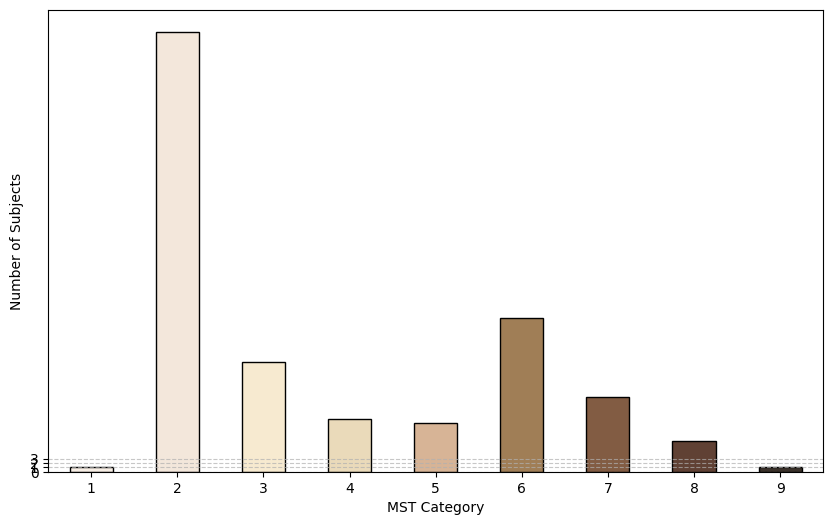

In [9]:
# Load the dataset with subject IDs and their MST category ground truth
df = pd.read_csv("../image_paths/ground_truth_CHROMA-FIT_forehead.csv")

subject_mst_mapping = df.set_index("ID")["Ground_Truth_Avg"]
mst_counts_by_subject = subject_mst_mapping.value_counts().sort_index()

# Plot the histogram with the assigned colors (replace MST_swatches with your color map if applicable)
bar_colors = mst_counts_by_subject.index.map(
    MST_swatches
)  # Replace MST_swatches with your actual color mapping
plt.figure(figsize=(10, 6))
mst_counts_by_subject.plot(kind="bar", color=bar_colors, edgecolor="black")

plt.xlabel("MST Category")
plt.ylabel("Number of Subjects")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.title('Number of Subjects per MST Category')
plt.show()

Plot MST-E dataset distribution

341


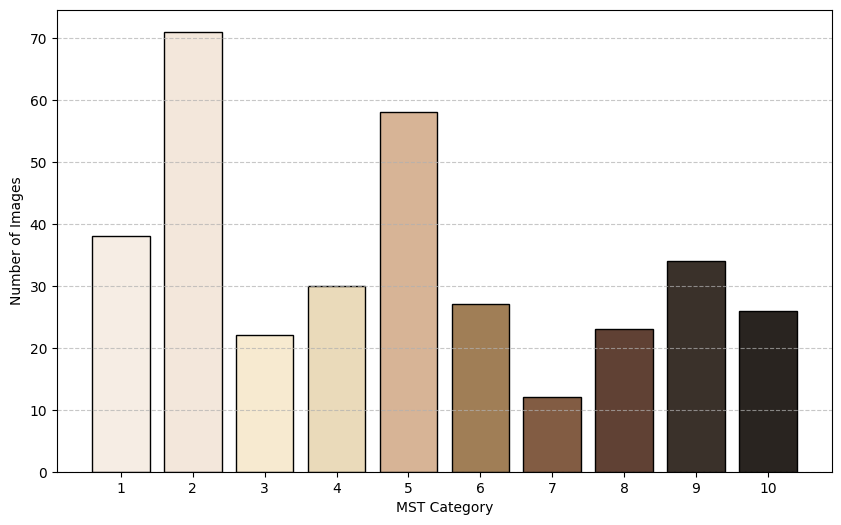

In [7]:
# MST_SUBJECT_MAPPING dictionary
MST_SUBJECT_MAPPING = {
    "subject_18": 1,
    "subject_17": 8,
    "subject_16": 1,
    "subject_15": 3,
    "subject_14": 6,
    "subject_13": 2,
    "subject_12": 10,
    "subject_11": 5,
    "subject_10": 9,
    "subject_9": 4,
    "subject_8": 2,
    "subject_7": 4,
    "subject_6": 5,
    "subject_5": 7,
    "subject_4": 9,
    "subject_3": 6,
    "subject_2": 8,
    "subject_1": 2,
    "subject_0": 3,
}

dataset_path = "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait"

mst_category_counts = {}

for subject, mst_category in MST_SUBJECT_MAPPING.items():
    subject_folder = os.path.join(dataset_path, subject)

    # Count the number of images in each MST category
    if os.path.exists(subject_folder):
        image_files = [
            f
            for f in os.listdir(subject_folder)
            if f.endswith((".jpg", ".png", ".jpeg"))
        ]
        num_images = len(image_files)

        if mst_category in mst_category_counts:
            mst_category_counts[mst_category] += num_images
        else:
            mst_category_counts[mst_category] = num_images


# Extract MST categories and their counts
mst_categories = list(mst_category_counts.keys())
num_images_per_category = list(mst_category_counts.values())

print(sum(num_images_per_category))


# Plot the data
bar_colors = [MST_swatches[mst_category] for mst_category in mst_categories]
plt.figure(figsize=(10, 6))
plt.bar(mst_categories, num_images_per_category, color=bar_colors, edgecolor="black")

plt.xlabel("MST Category")
plt.ylabel("Number of Images")
plt.xticks(mst_categories)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

19


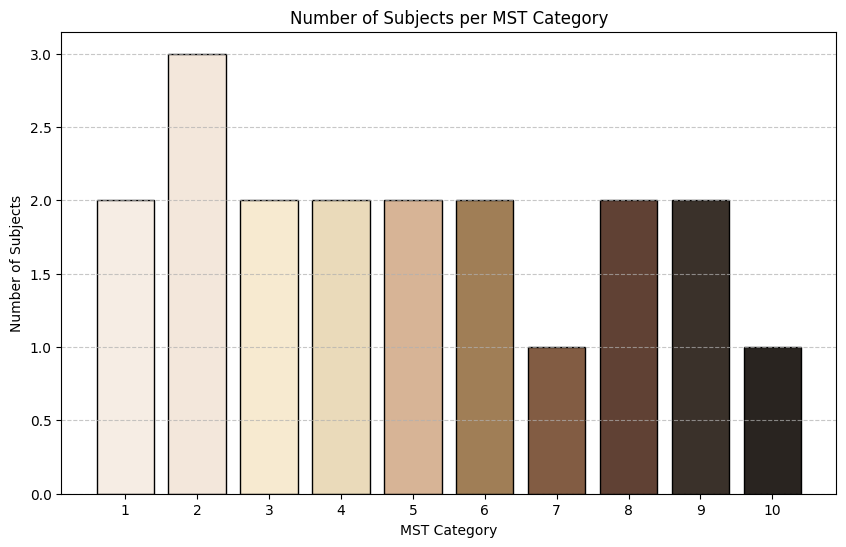

In [8]:
dataset_path = "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait"

mst_subject_counts = {}

# Count the number of subjects per MST category
for subject, mst_category in MST_SUBJECT_MAPPING.items():
    subject_folder = os.path.join(dataset_path, subject)

    if os.path.exists(subject_folder):
        if mst_category in mst_subject_counts:
            mst_subject_counts[mst_category] += 1
        else:
            mst_subject_counts[mst_category] = 1

# Extract MST categories and their subject counts
mst_categories = list(mst_subject_counts.keys())
num_subjects_per_category = list(mst_subject_counts.values())

# Plot the data
bar_colors = [MST_swatches[mst_category] for mst_category in mst_categories]
plt.figure(figsize=(10, 6))
plt.bar(mst_categories, num_subjects_per_category, color=bar_colors, edgecolor="black")

plt.xlabel("MST Category")
plt.ylabel("Number of Subjects")
plt.xticks(mst_categories)
plt.yticks(range(0, max(num_subjects_per_category) + 1, 1))
# plt.title('Number of Subjects per MST Category')
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Visualise images of each MST category

Shows the ground truth classification of images.

In [ ]:
base_path = (
    "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2"
)
mst_ratings_data = pd.read_csv("image_paths/ground_truth_CHROMA-FIT.csv")

mst_categories = mst_ratings_data["Ground_Truth_MST"].unique()
mst_images = {mst: [] for mst in mst_categories}

for index, row in mst_ratings_data.iterrows():
    folder_id = f"{int(row['ID']):05d}"
    folder_path = os.path.join(base_path, folder_id)

    if os.path.exists(folder_path):
        files = os.listdir(folder_path)

        image_files = [
            f for f in files if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        for image in image_files:
            mst_images[row["Ground_Truth_MST"]].append(os.path.join(folder_path, image))

# Display images for each MST category
for mst, images in mst_images.items():

    plt.figure(figsize=(15, 10))
    plt.suptitle(f"MST Category: {mst}", fontsize=16)

    num_images = len(images)
    cols = 12
    rows = (num_images // cols) + (num_images % cols > 0)

    # Plot each image in a subplot
    for i, img_path in enumerate(images):
        img = plt.imread(img_path)
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")

        file_name = os.path.basename(img_path)
        ax.set_title(file_name, fontsize=10, pad=5)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Display all MST images by their category

In [ ]:
MST_SUBJECT_MAPPING = {
    "subject_18": 1,
    "subject_17": 8,
    "subject_16": 1,
    "subject_15": 3,
    "subject_14": 6,
    "subject_13": 2,
    "subject_12": 10,
    "subject_11": 5,
    "subject_10": 9,
    "subject_9": 4,
    "subject_8": 2,
    "subject_7": 4,
    "subject_6": 5,
    "subject_5": 7,
    "subject_4": 9,
    "subject_3": 6,
    "subject_2": 8,
    "subject_1": 2,
    "subject_0": 3,
}

baseline_utils.plot_images_by_mst_category(
    MST_SUBJECT_MAPPING,
    "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait",
)

# Calculate the predicted MST category for CHROMA-FIT dataset

In [27]:
import json

# NOTE: Change the file name to the required one for indoor and outdoor images

results_file = (
    "../baseline/results/cheek_colors_extracted/MST_exposure_color_correction.json"
)
save_predicted_file = (
    "../baseline/results/predicted_MST/MST_exposure_color_correction.csv"
)

mst_orb_dir = "/home/dasec-notebook/Thesis/Datasets/MST Orbs/orbs"

with open(results_file, "r") as file:
    mst_data = json.load(file)

# Load all MST orb salient colors in a dictionary
mst_orb_salient_colors = {}
for filename in os.listdir(mst_orb_dir):
    if filename.endswith(".png"):  # Assumes MST orbs are PNG images
        image_path = os.path.join(mst_orb_dir, filename)
        salient_colors = baseline_utils.extract_salient_colors(image_path)
        mst_orb_salient_colors[filename] = salient_colors

# Prepare results
mst_results = []

# # Iterate over each subject in the JSON data
for subject_id, subject_data in mst_data.items():

    for image_name, image_data in subject_data.items():

        avg_cheek_rgb = image_data["avg_cheek_color"]
        left_cheek_rgb = image_data["left_cheek_color"]
        right_cheek_rgb = image_data["right_cheek_color"]

        if avg_cheek_rgb != None:

            best_mst_orb, lowest_rmse = baseline_utils.calculate_best_mst_orb(
                avg_cheek_rgb, mst_orb_salient_colors
            )

        elif left_cheek_rgb != None:
            best_mst_orb, lowest_rmse = baseline_utils.calculate_best_mst_orb(
                left_cheek_rgb, mst_orb_salient_colors
            )

        elif right_cheek_rgb != None:
            best_mst_orb, lowest_rmse = baseline_utils.calculate_best_mst_orb(
                right_cheek_rgb, mst_orb_salient_colors
            )

        else:
            continue

        mst_results.append(
            {
                "ID": subject_id.split("_")[
                    1
                ],  # str(int(subject_id)), #NOTE: switch for CHROMA-fit and MST data formatting
                "Image": image_name,
                "Best_MST_Orb": best_mst_orb,  # Best MST orb file for this subject
                "Lowest_RMSE": lowest_rmse,
            }
        )

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(mst_results)
results_df.to_csv(save_predicted_file, index=False)

print("Best MST orbs calculated and saved")

Best MST orbs calculated and saved


# Calculate the prediction accuracy for CHROMA-FIT dataset

In [ ]:
predictions = pd.read_csv("../baseline/results/predicted_MST/CHROMA-FIT_indoor.csv")
img_file_path = "../image_paths/CHROMA-FIT_indoor.txt"
save_results_file = "../baseline/results/cheek_MST_accuracy/CHROMA-FIT_indoor.csv"

ground_truth = pd.read_csv("../image_paths/ground_truth_CHROMA-FIT_forehead.csv")

# Calculate predictions for the images specified in the img_file_path
# Some images were removed from the dataset due to incorrect measurements
with open(img_file_path, "r") as f:
    img_paths = f.read().splitlines()

img_files = [path.split("/")[-1] for path in img_paths]

filtered_predictions = predictions[predictions["Image"].isin(img_files)]
filtered_predictions["Most_Frequent_Best_MST_Orb"] = filtered_predictions.groupby("ID")[
    "Best_MST_Orb"
].transform(lambda x: x.mode()[0])

# Select unique combinations of ID and Most_Frequent_Best_MST_Orb for merging
most_frequent_predictions = filtered_predictions[["ID", "Most_Frequent_Best_MST_Orb"]]
most_frequent_predictions.columns = ["ID", "Best_MST_Orb_pred"]
merged_data = pd.merge(most_frequent_predictions, ground_truth, on="ID")

results_per_category = {}

count = 0

for category in merged_data["Ground_Truth_Avg"].unique():

    category_data = merged_data[merged_data["Ground_Truth_Avg"] == category]
    exact_match_predictions = (
        category_data["Best_MST_Orb_pred"] == category_data["Ground_Truth_Avg"]
    ).sum()

    # Correct the within ±1 and ±2 calculations
    within_pm1_predictions = (
        abs(category_data["Best_MST_Orb_pred"] - category_data["Ground_Truth_Avg"]) <= 1
    ).sum()
    within_pm2_predictions = (
        abs(category_data["Best_MST_Orb_pred"] - category_data["Ground_Truth_Avg"]) <= 2
    ).sum()

    total_predictions = (merged_data["Ground_Truth_Avg"] == category).sum()

    results_per_category[category] = {
        "Exact_Match_Accuracy": (
            (exact_match_predictions / total_predictions) * 100
            if total_predictions > 0
            else 0
        ),
        "PM1_Accuracy": (
            (within_pm1_predictions / total_predictions) * 100
            if total_predictions > 0
            else 0
        ),
        "PM2_Accuracy": (
            (within_pm2_predictions / total_predictions) * 100
            if total_predictions > 0
            else 0
        ),
        "Photos_Included": total_predictions,
    }

    count = count + 1

# Print the results for each MST category
for category, metrics in results_per_category.items():
    print(
        f"MST category {category}: "
        f"Exact Match Accuracy = {metrics['Exact_Match_Accuracy']:.2f}%, "
        f"±1 Category Accuracy = {metrics['PM1_Accuracy']:.2f}%, "
        f"±2 Category Accuracy = {metrics['PM2_Accuracy']:.2f}%, "
        f"Photos Included = {metrics['Photos_Included']}"
    )

results_per_category = dict(sorted(results_per_category.items()))

# Save the results to a CSV file
results_df = pd.DataFrame.from_dict(results_per_category, orient="index")
results_df.to_csv(save_results_file)

# Calculate the prediction accuracy for MST dataset

In [ ]:
prediction_file = "../baseline/results/predicted_MST/MST.csv"
mst_results_save = "../baseline/results/cheek_MST_accuracy/MST.csv"

MST_SUBJECT_MAPPING = {
    "subject_18": 1,
    "subject_17": 8,
    "subject_16": 1,
    "subject_15": 3,
    "subject_14": 6,
    "subject_13": 2,
    "subject_12": 10,
    "subject_11": 5,
    "subject_10": 9,
    "subject_9": 4,
    "subject_8": 2,
    "subject_7": 4,
    "subject_6": 5,
    "subject_5": 7,
    "subject_4": 9,
    "subject_3": 6,
    "subject_2": 8,
    "subject_1": 2,
    "subject_0": 3,
}

ground_truth_df = pd.DataFrame(
    list(MST_SUBJECT_MAPPING.items()), columns=["Subject", "Best_MST_Orb"]
)

ground_truth_df["ID"] = ground_truth_df["Subject"].str.extract("(\d+)").astype(int)

predictions = pd.read_csv(prediction_file)
merged_data = pd.merge(
    predictions,
    ground_truth_df[["ID", "Best_MST_Orb"]],
    on="ID",
    suffixes=("", "_truth"),
)
merged_data.rename(columns={"Best_MST_Orb_truth": "Ground_Truth_MST_Orb"}, inplace=True)

results_per_category = {}

# Loop over each unique MST category in the ground truth
for category in merged_data["Ground_Truth_MST_Orb"].unique():

    category_data = merged_data[merged_data["Ground_Truth_MST_Orb"] == category]
    exact_match_predictions = (
        category_data["Best_MST_Orb"] == category_data["Ground_Truth_MST_Orb"]
    ).sum()

    # Correct the within ±1 and ±2 calculations
    within_pm1_predictions = (
        abs(category_data["Best_MST_Orb"] - category_data["Ground_Truth_MST_Orb"]) <= 1
    ).sum()
    within_pm2_predictions = (
        abs(category_data["Best_MST_Orb"] - category_data["Ground_Truth_MST_Orb"]) <= 2
    ).sum()

    total_predictions = (merged_data["Ground_Truth_MST_Orb"] == category).sum()

    results_per_category[category] = {
        "Exact_Match_Accuracy": (
            (exact_match_predictions / total_predictions) * 100
            if total_predictions > 0
            else 0
        ),
        "PM1_Accuracy": (
            (within_pm1_predictions / total_predictions) * 100
            if total_predictions > 0
            else 0
        ),
        "PM2_Accuracy": (
            (within_pm2_predictions / total_predictions) * 100
            if total_predictions > 0
            else 0
        ),
        "Photos_Included": total_predictions,
    }

results_per_category = dict(sorted(results_per_category.items()))

# Print the results for each MST category
for category, metrics in results_per_category.items():
    print(
        f"MST category {category}: "
        f"Exact Match Accuracy = {metrics['Exact_Match_Accuracy']:.2f}%, "
        f"±1 Category Accuracy = {metrics['PM1_Accuracy']:.2f}%, "
        f"±2 Category Accuracy = {metrics['PM2_Accuracy']:.2f}%, "
        f"Photos Included = {metrics['Photos_Included']}"
    )

# Save the results to a CSV file
results_df = pd.DataFrame.from_dict(results_per_category, orient="index")
results_df.to_csv(mst_results_save)